<a href="https://colab.research.google.com/github/PalepuRohith/Generative-Ai-/blob/main/English_to_French_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import tensorflow as tf

In [61]:
text_file = tf.keras.utils.get_file(
    fname='fra-eng.zip',
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True
)

In [62]:
import pathlib
import unicodedata
import re

In [63]:
text_file = pathlib.Path(text_file).parent / 'fra.txt'

In [64]:
def normalize(line):
    line = unicodedata.normalize("NFKC", line.strip().lower())
    line = re.sub(r"^([^ \w])(?!\s)", r"\1", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1", line)
    line = re.sub(r"(?!\s)([^ \w])$", r"\1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r"\1", line)
    eng, fre = line.split("\t")
    fre = '[start] ' + fre + ' [end]'
    return eng, fre


In [65]:
with open(text_file) as fp:
    text_pairs = [normalize(line) for line in fp]

In [66]:
eng_tokens, fre_tokens = set(), set()
eng_maxlen, fre_maxlen = 0, 0
for eng, fre in text_pairs:
    eng_token, fre_token = eng.split(), fre.split()
    eng_maxlen = max(eng_maxlen, len(eng_token))
    fre_maxlen = max(fre_maxlen, len(fre_token))
    eng_tokens.update(eng_token)
    fre_tokens.update(fre_token)

In [67]:
print(f"Total tokens in English: {len(eng_tokens)}")
print(f"Total tokens in French: {len(fre_tokens)}")
print(f"Maximum length of English sequence: {eng_maxlen}")
print(f"Maximum length of French sequence: {fre_maxlen}")

Total tokens in English: 25365
Total tokens in French: 42027
Maximum length of English sequence: 47
Maximum length of French sequence: 56


In [68]:
import pickle

In [69]:
with open("text_pairs.pickle", 'wb') as fp:
    pickle.dump(text_pairs, fp)

In [70]:
from tensorflow.keras.layers import TextVectorization
import pickle
with open('text_pairs.pickle', 'rb') as fp:
    text_pairs = pickle.load(fp)

In [71]:
import random
random.shuffle(text_pairs)

In [72]:
n_val = int(.15*len(text_pairs))
n_train = len(text_pairs) - 2*n_val
train_pair = text_pairs[:n_train]
test_pair = text_pairs[n_train:n_train+n_val]

In [73]:
vocab_en = 10000
vocab_fr = 20000
seq_length = 25

In [74]:
eng_vect = TextVectorization(
    max_tokens = vocab_en,
    standardize = None,
    split = 'whitespace',
    output_mode = 'int',
    output_sequence_length = seq_length
)

In [75]:
fre_vect = TextVectorization(
    max_tokens = vocab_fr,
    standardize = None,
    split = 'whitespace',
    output_mode = 'int',
    output_sequence_length = seq_length+1
)

In [76]:
eng_text, fre_text = zip(*train_pair)

In [77]:
eng_vect.adapt(eng_text)
fre_vect.adapt(fre_text)

In [78]:
eng_vect

<TextVectorization name=text_vectorization_2, built=False>

In [79]:
with open('vectorize.pickle', 'wb') as fp:
  data = {'train': train_pair,
          'test' : test_pair,
          'eng_vect' : eng_vect.get_config(),
          'fre_vect' : fre_vect.get_config(),
          'eng_weights' : eng_vect.get_weights(),
          'fre_weights' : fre_vect.get_weights()
          }
  pickle.dump(data, fp)

In [80]:
with open('vectorize.pickle', 'rb') as fp:
  data = pickle.load(fp)

In [81]:
train_pairs = data['train']
test_pairs = data['test']

In [82]:
eng_vect = TextVectorization.from_config(data['eng_vect'])
eng_vect.set_weights(data['eng_weights'])
fre_vect = TextVectorization.from_config(data['fre_vect'])
fre_vect.set_weights(data['fre_weights'])

In [83]:
def format_dataset(eng, fre):
    eng = eng_vect(eng)
    fre = fre_vect(fre)
    source = {'encode_inp' : eng,
              'decode_inp' : fre[:, :-1]
              }
    target = fre[:, 1:]
    return(source,target)

In [84]:
def make_dataset(pairs, batchsize=64):
  eng_text, fre_text = zip(*pairs)
  eng_vect.adapt(eng_text)
  fre_vect.adapt(fre_text)
  dataset = tf.data.Dataset.from_tensor_slices((list(eng_text), list(fre_text)))
  return dataset.shuffle(2048).batch(batchsize).map(format_dataset).prefetch(16).cache()

In [85]:
train_ds = make_dataset(train_pairs)
test_ds = make_dataset(test_pairs)

In [86]:
train_ds

<CacheDataset element_spec=({'encode_inp': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'decode_inp': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [87]:
for inputs, target in train_ds.take(1):
  print(inputs['encode_inp'].shape)
  print(inputs['encode_inp'][0])
  print(inputs['decode_inp'].shape)
  print(inputs['decode_inp'][0])
  print(target.shape)
  print(target[0])




(64, 25)
tf.Tensor(
[  2  31   4 460   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)
(64, 25)
tf.Tensor(
[  2 191  33  12 543   3   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)
(64, 25)
tf.Tensor(
[191  33  12 543   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


In [88]:
import numpy as np

import tensorflow as tf
def pos_enc_matrix(L, d, n =10000):
  assert d%2 ==0
  d2 = d//2


  P = np.zeros((L,d))
  k = np.arange(L).reshape(-1,1)
  i = np.arange(d2).reshape(1,-1)
  denom = np.power(n, -i/d2)
  args = k*denom
  P[:, ::2] = np.sin(args)
  P[:, 1::2] = np.cos(args)
  return P


In [89]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, seq_length, vocab_size, embed_dim,**kwargs):
    super().__init__(**kwargs)
    self.seq_length = seq_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim
    self.token_embeddings = tf.keras.layers.Embedding( input_dim=vocab_size, output_dim=embed_dim, mask_zero = True )
    matrix = pos_enc_matrix(seq_length, embed_dim)
    self.positional_embeddings = tf.constant(matrix, dtype = tf.float32)
  def  call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    return embedded_tokens + self.positional_embeddings
  def compute_mask(self, *args, **kwargs):
    return self.token_embeddings.compute_mask(*args, **kwargs)

  def get_config(self):
    config = super().get_config()
    config.update({
        'seq_length' : self.seq_length,
        'vocab_size' : self.vocab_size,
        'embed_dim' : self.embed_dim
    })
    return config

In [90]:
vocab_size = 10000
seq_length = 25

In [91]:
for inputs, target in train_ds.take(1):
  print(inputs['encode_inp'])
  embed_en = PositionalEmbedding(seq_length, vocab_size, embed_dim=512)
  en_emb = embed_en(inputs['encode_inp'])
  print(en_emb._keras_mask)

tf.Tensor(
[[   2  166   63 ...    0    0    0]
 [  39  219 3185 ...    0    0    0]
 [   5  583    7 ...    0    0    0]
 ...
 [  25  136  154 ...    0    0    0]
 [ 179  243    6 ...    0    0    0]
 [ 123  282 4094 ...    0    0    0]], shape=(64, 25), dtype=int64)
tf.Tensor(
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]], shape=(64, 25), dtype=bool)


SELF ATTENTION MODEL
it processes single type of data

In [92]:
import tensorflow as tf

def self_attention(input_shape, prefix='att', mask=False, **kwargs):
    # Define inputs
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in1")

    # Multi-head attention layer
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_att1", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f'{prefix}_norm1')
    add = tf.keras.layers.Add(name=f'{prefix}_add1')

    # Apply attention mechanism
    attout = attention(query=inputs, value=inputs, key=inputs, use_causal_mask=mask)

    # Apply normalization and residual connection
    output = norm(add([inputs, attout]))

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=output, name=f"{prefix}_att")

    return model


In [93]:
seq_length = 25
key_dim = 128
num_heads = 8
model = self_attention(input_shape=(seq_length, key_dim), num_heads=num_heads, key_dim=key_dim)

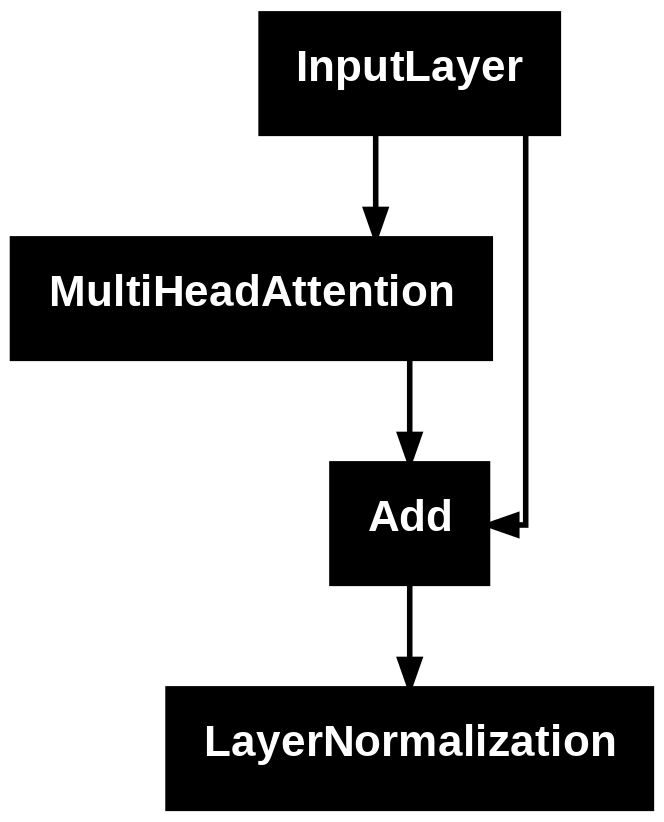

In [94]:
tf.keras.utils.plot_model(model)

CROSS ATTENTION MODEL
it combines data from different sources

In [95]:
def cross_attention(input_shape, context_shape, prefix='att', **kwargs):
    # Define inputs
    context = tf.keras.layers.Input(shape=context_shape, dtype='float32', name=f"{prefix}_ctx2")
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_in2')

    # Multi-head attention layer
    attention = tf.keras.layers.MultiHeadAttention(name=f'{prefix}_att2', **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f'{prefix}_norm2')
    add = tf.keras.layers.Add(name=f'{prefix}_add2')

    # Apply attention mechanism
    attout = attention(query=inputs, key=context, value=context)

    # Apply normalization and residual connection
    output = norm(add([attout, inputs]))

    # Create the model
    model = tf.keras.Model(inputs=[context, inputs], outputs=output, name=f'{prefix}_crs_at')

    return model


In [96]:
model = cross_attention(input_shape=(seq_length, key_dim), context_shape=(seq_length, key_dim), num_heads=num_heads, key_dim=key_dim)

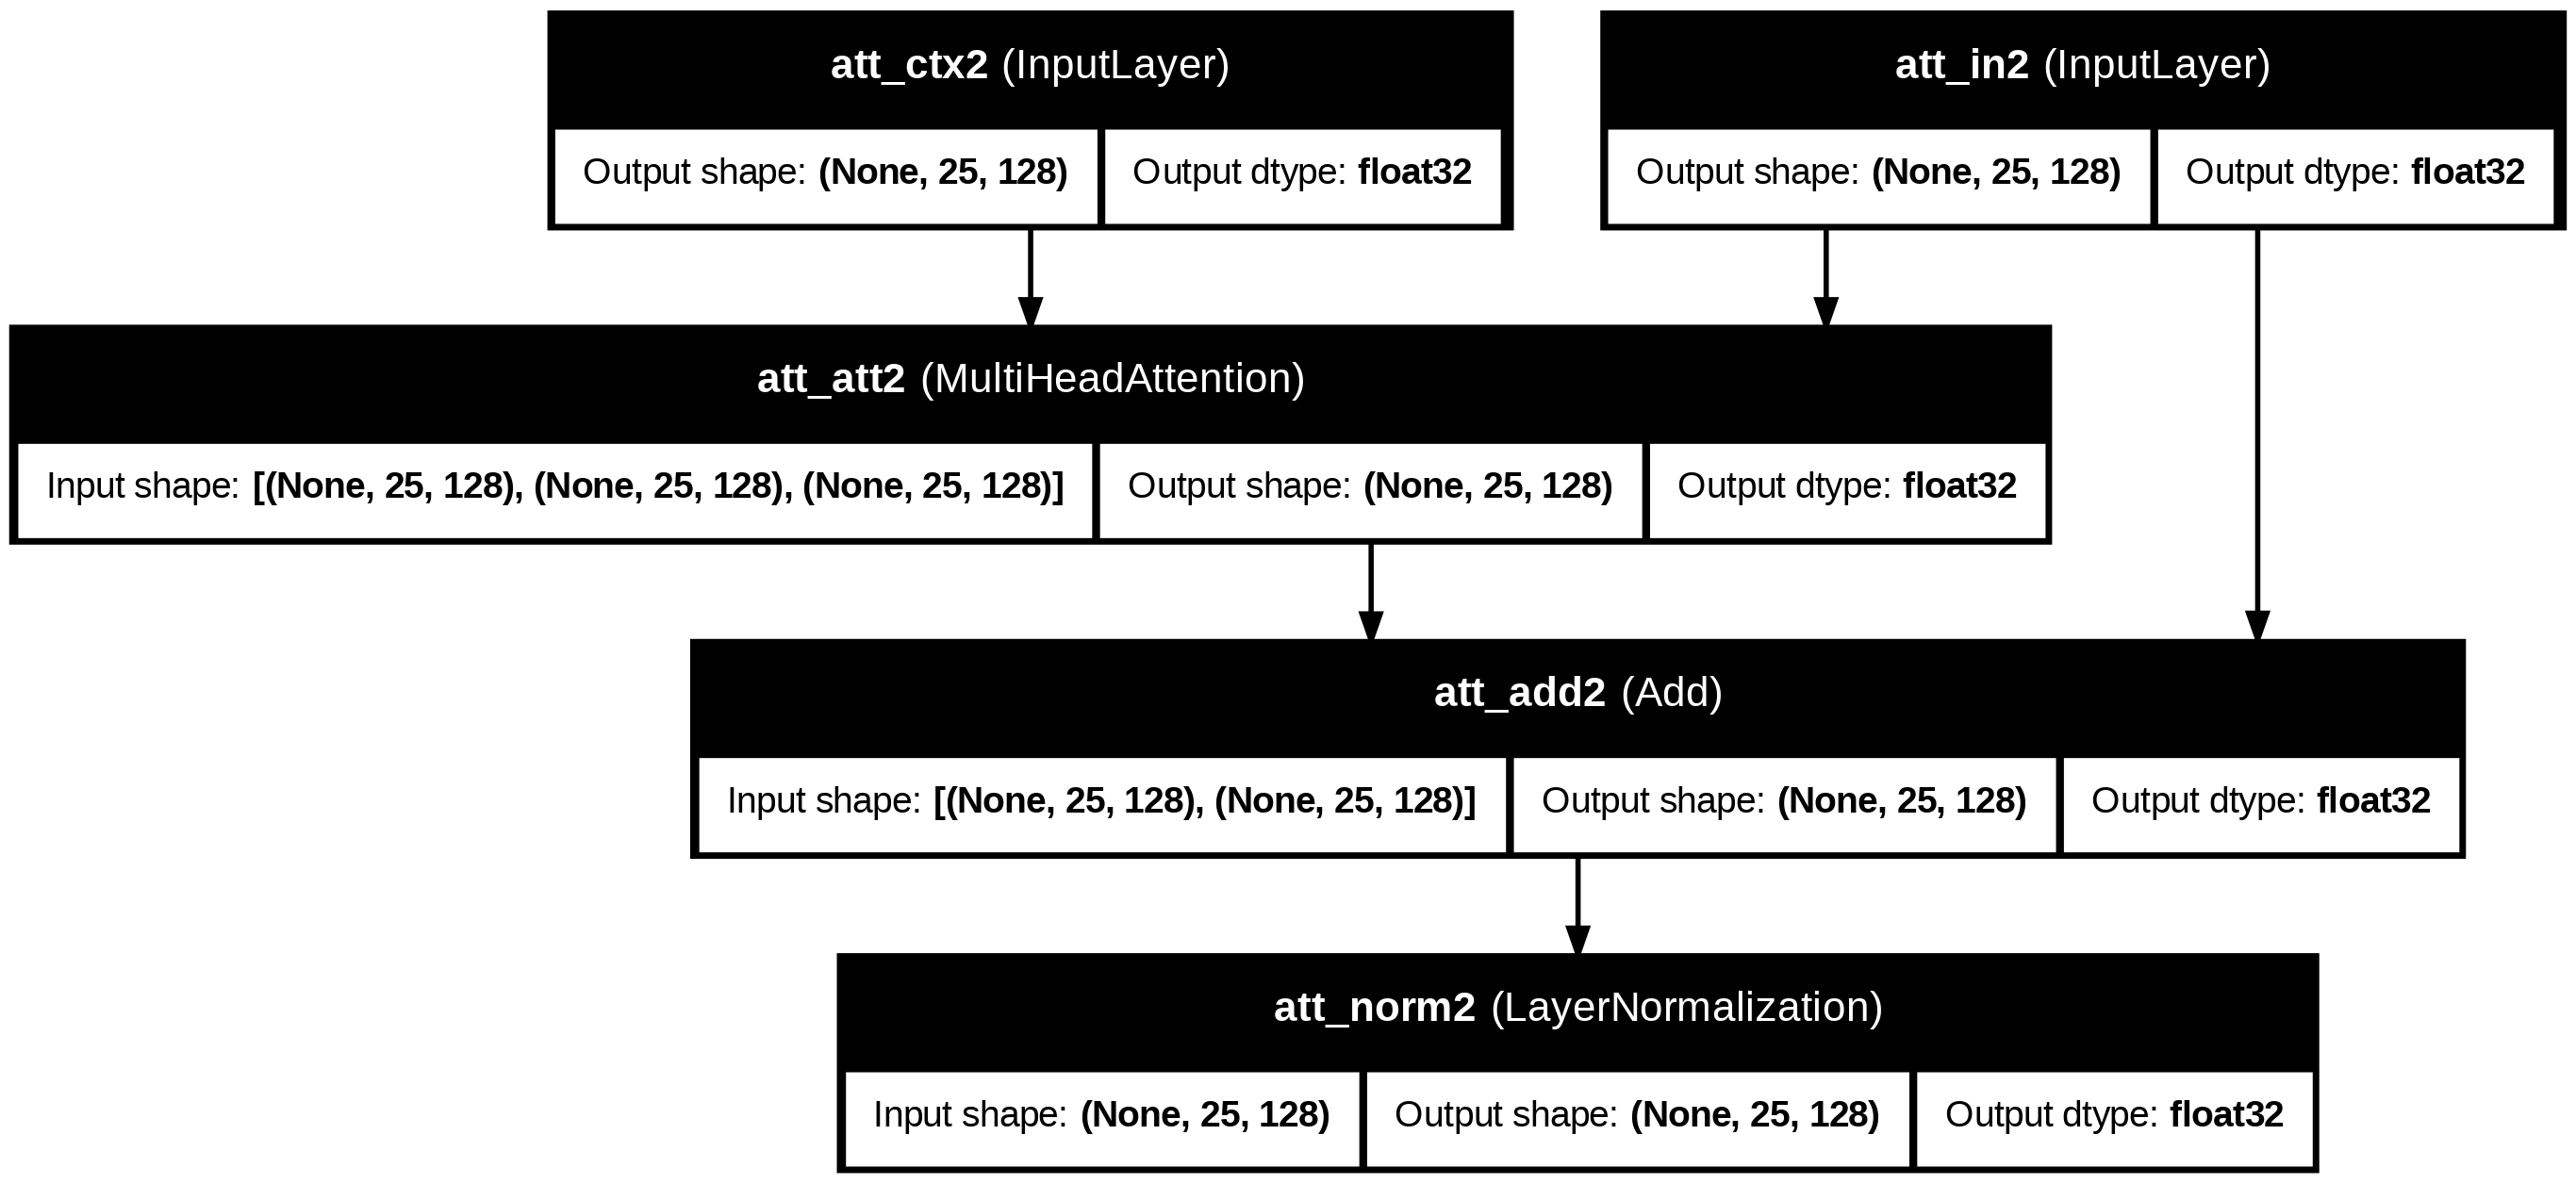

In [97]:
tf.keras.utils.plot_model(model,show_shapes = True, show_dtype = True, show_layer_names = True, show_layer_activations = True )

FEED FORWARD NEURAL NETWORK:
we use dropout layer to avoid overfitting

In [98]:
def feed_forward(input_shape, model_dim, ff_dim, dropout=.1, prefix='ff'):
    # Define inputs
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_in3')

    # Dense layers
    dense1 = tf.keras.layers.Dense(ff_dim, name=f'{prefix}_ff1', activation='relu')
    dense2 = tf.keras.layers.Dense(model_dim, name=f'{prefix}_ff2')
    drop = tf.keras.layers.Dropout(dropout, name=f'{prefix}_drop')
    add = tf.keras.layers.Add(name=f"{prefix}_add3")

    # Apply feed-forward transformation
    ffout = drop(dense2(dense1(inputs)))

    # Layer normalization and residual connection
    norm = tf.keras.layers.LayerNormalization(name=f'{prefix}_norm3')
    output = norm(add([inputs, ffout]))

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=output, name=f'{prefix}_ff')

    return model


In [99]:
ff_dim = 512

In [100]:
model = feed_forward(input_shape=(seq_length, key_dim), model_dim=key_dim, ff_dim = ff_dim)

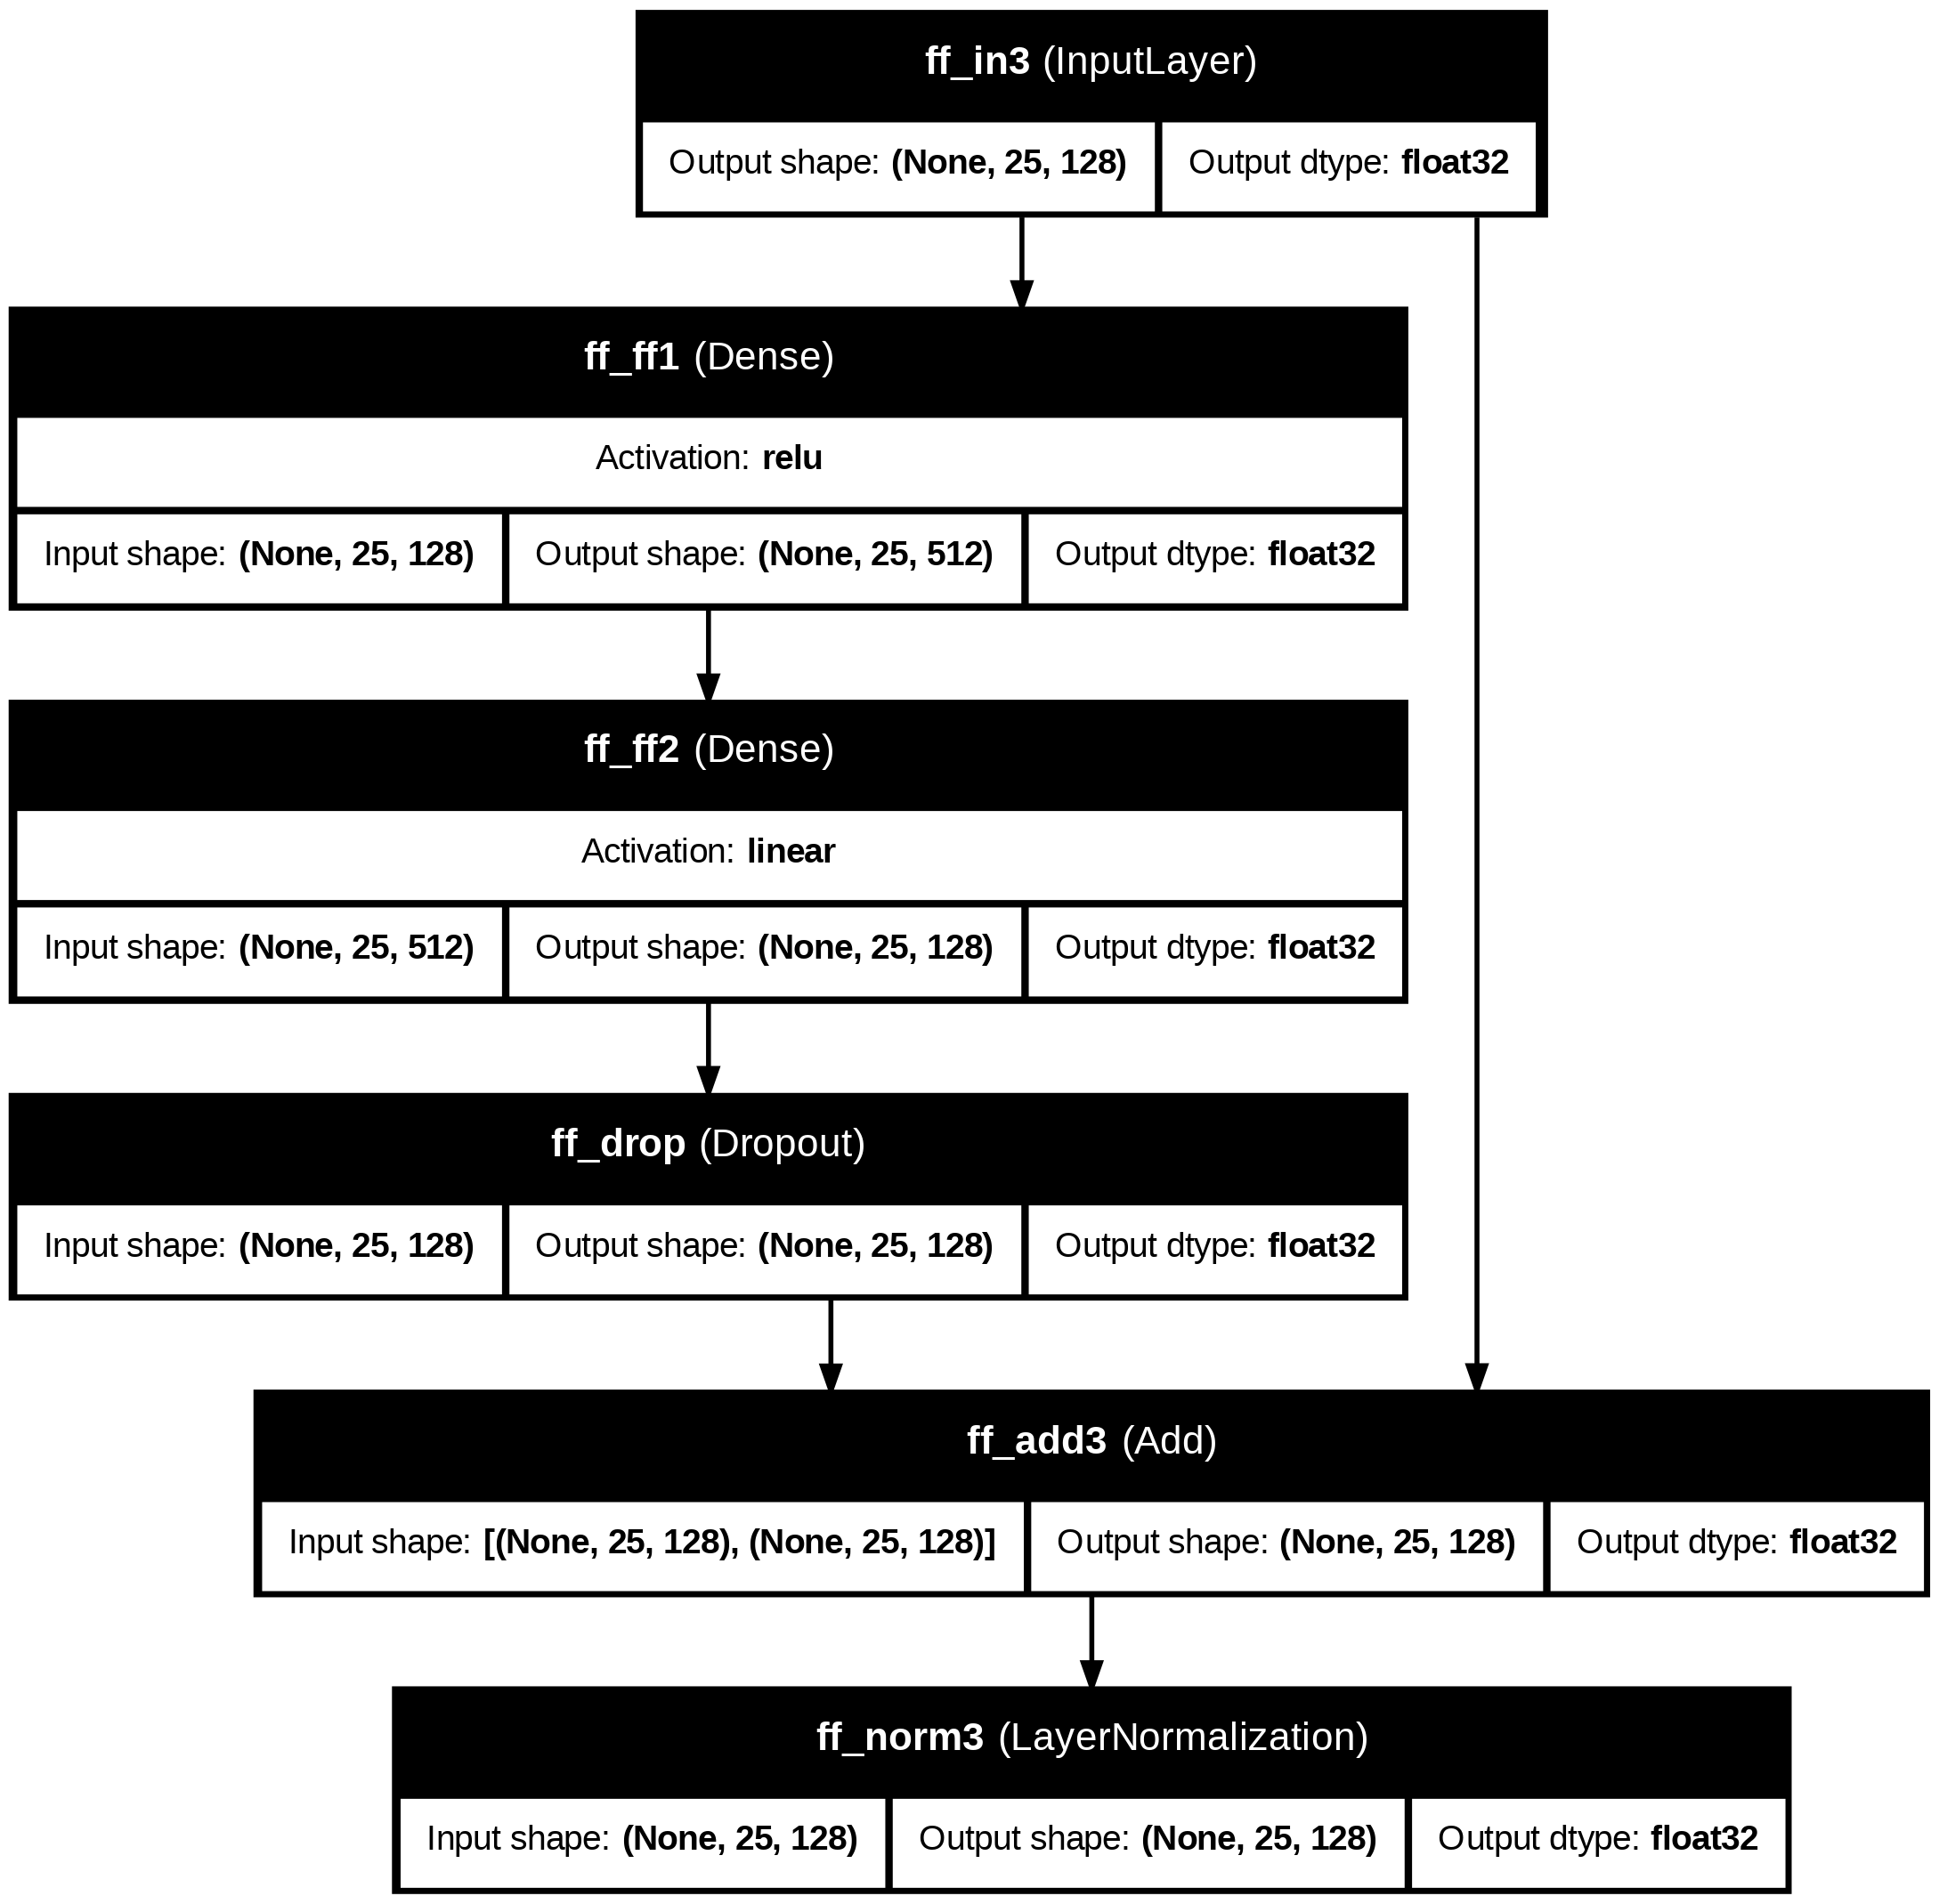

In [101]:
tf.keras.utils.plot_model(model,show_shapes = True, show_dtype = True, show_layer_names = True, show_layer_activations = True )

In [102]:
def encoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix = 'enc', **kwargs):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f'{prefix}_in0')
      ,self_attention(input_shape= input_shape, prefix = prefix, key_dim = key_dim, mask = False, **kwargs)
      , feed_forward(input_shape = input_shape, model_dim = key_dim, ff_dim = ff_dim, dropout=dropout, prefix = prefix)
  ])
  return model


In [103]:
seq_length = 25
key_dim = 128
ff_dim = 512
num_heads = 8

In [104]:
model = encoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim, num_heads = num_heads)

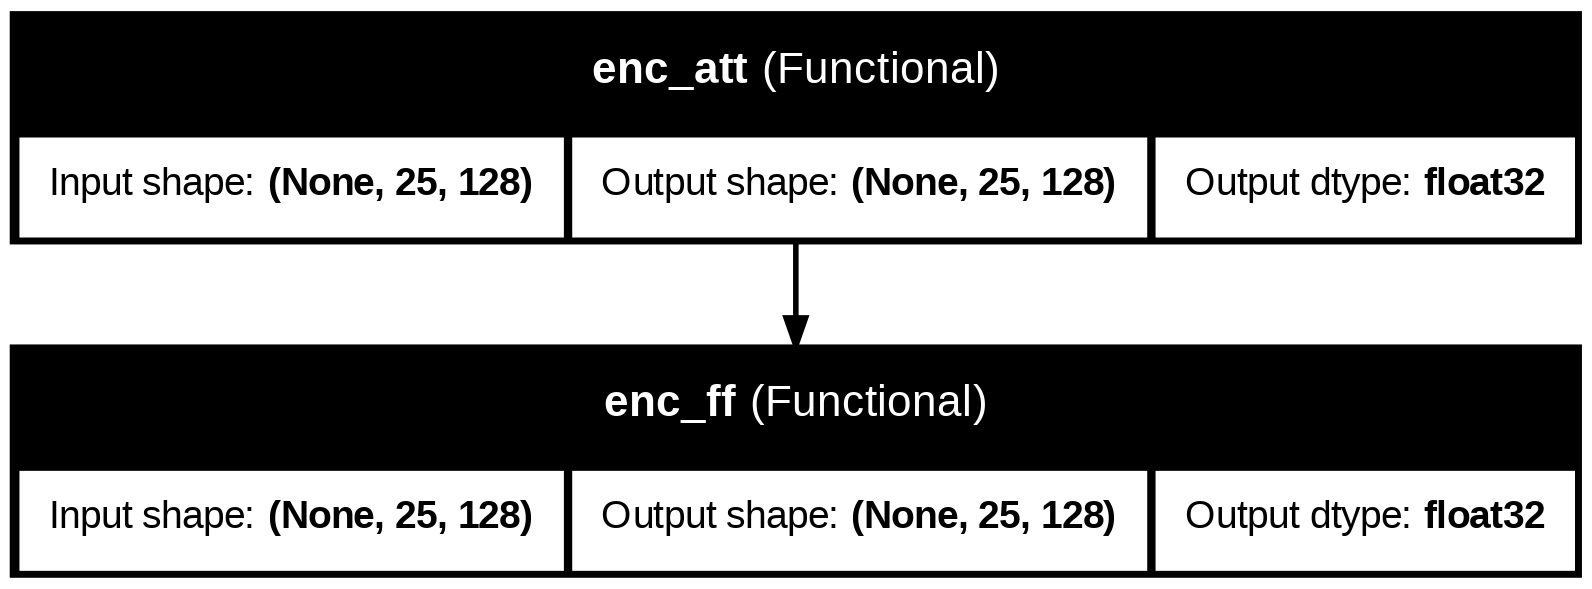

In [105]:
tf.keras.utils.plot_model(model,show_shapes = True, show_dtype = True, show_layer_names = True, show_layer_activations = True )

In [106]:
def decoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix='dec', **kwargs):
        inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_in0')
        context = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_ctx0')

        # Self-attention and cross-attention layers
        att_model = self_attention(input_shape, key_dim=key_dim, mask=True, prefix=prefix, **kwargs)
        cross_model = cross_attention(input_shape, input_shape, key_dim=key_dim, prefix=prefix, **kwargs)

        # Feed-forward layer
        ff_model = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)

        # Connect layers, explicitly passing the output of one layer as input to the next
        x = att_model(inputs)
        x = cross_model([context, x])
        output = ff_model(x)

        # Define decoder model
        model = tf.keras.Model(inputs=[inputs, context], outputs=output, name=prefix)

        return model


In [107]:
model = decoder(input_shape = (seq_length, key_dim ),key_dim= key_dim, ff_dim = ff_dim, num_heads = num_heads)

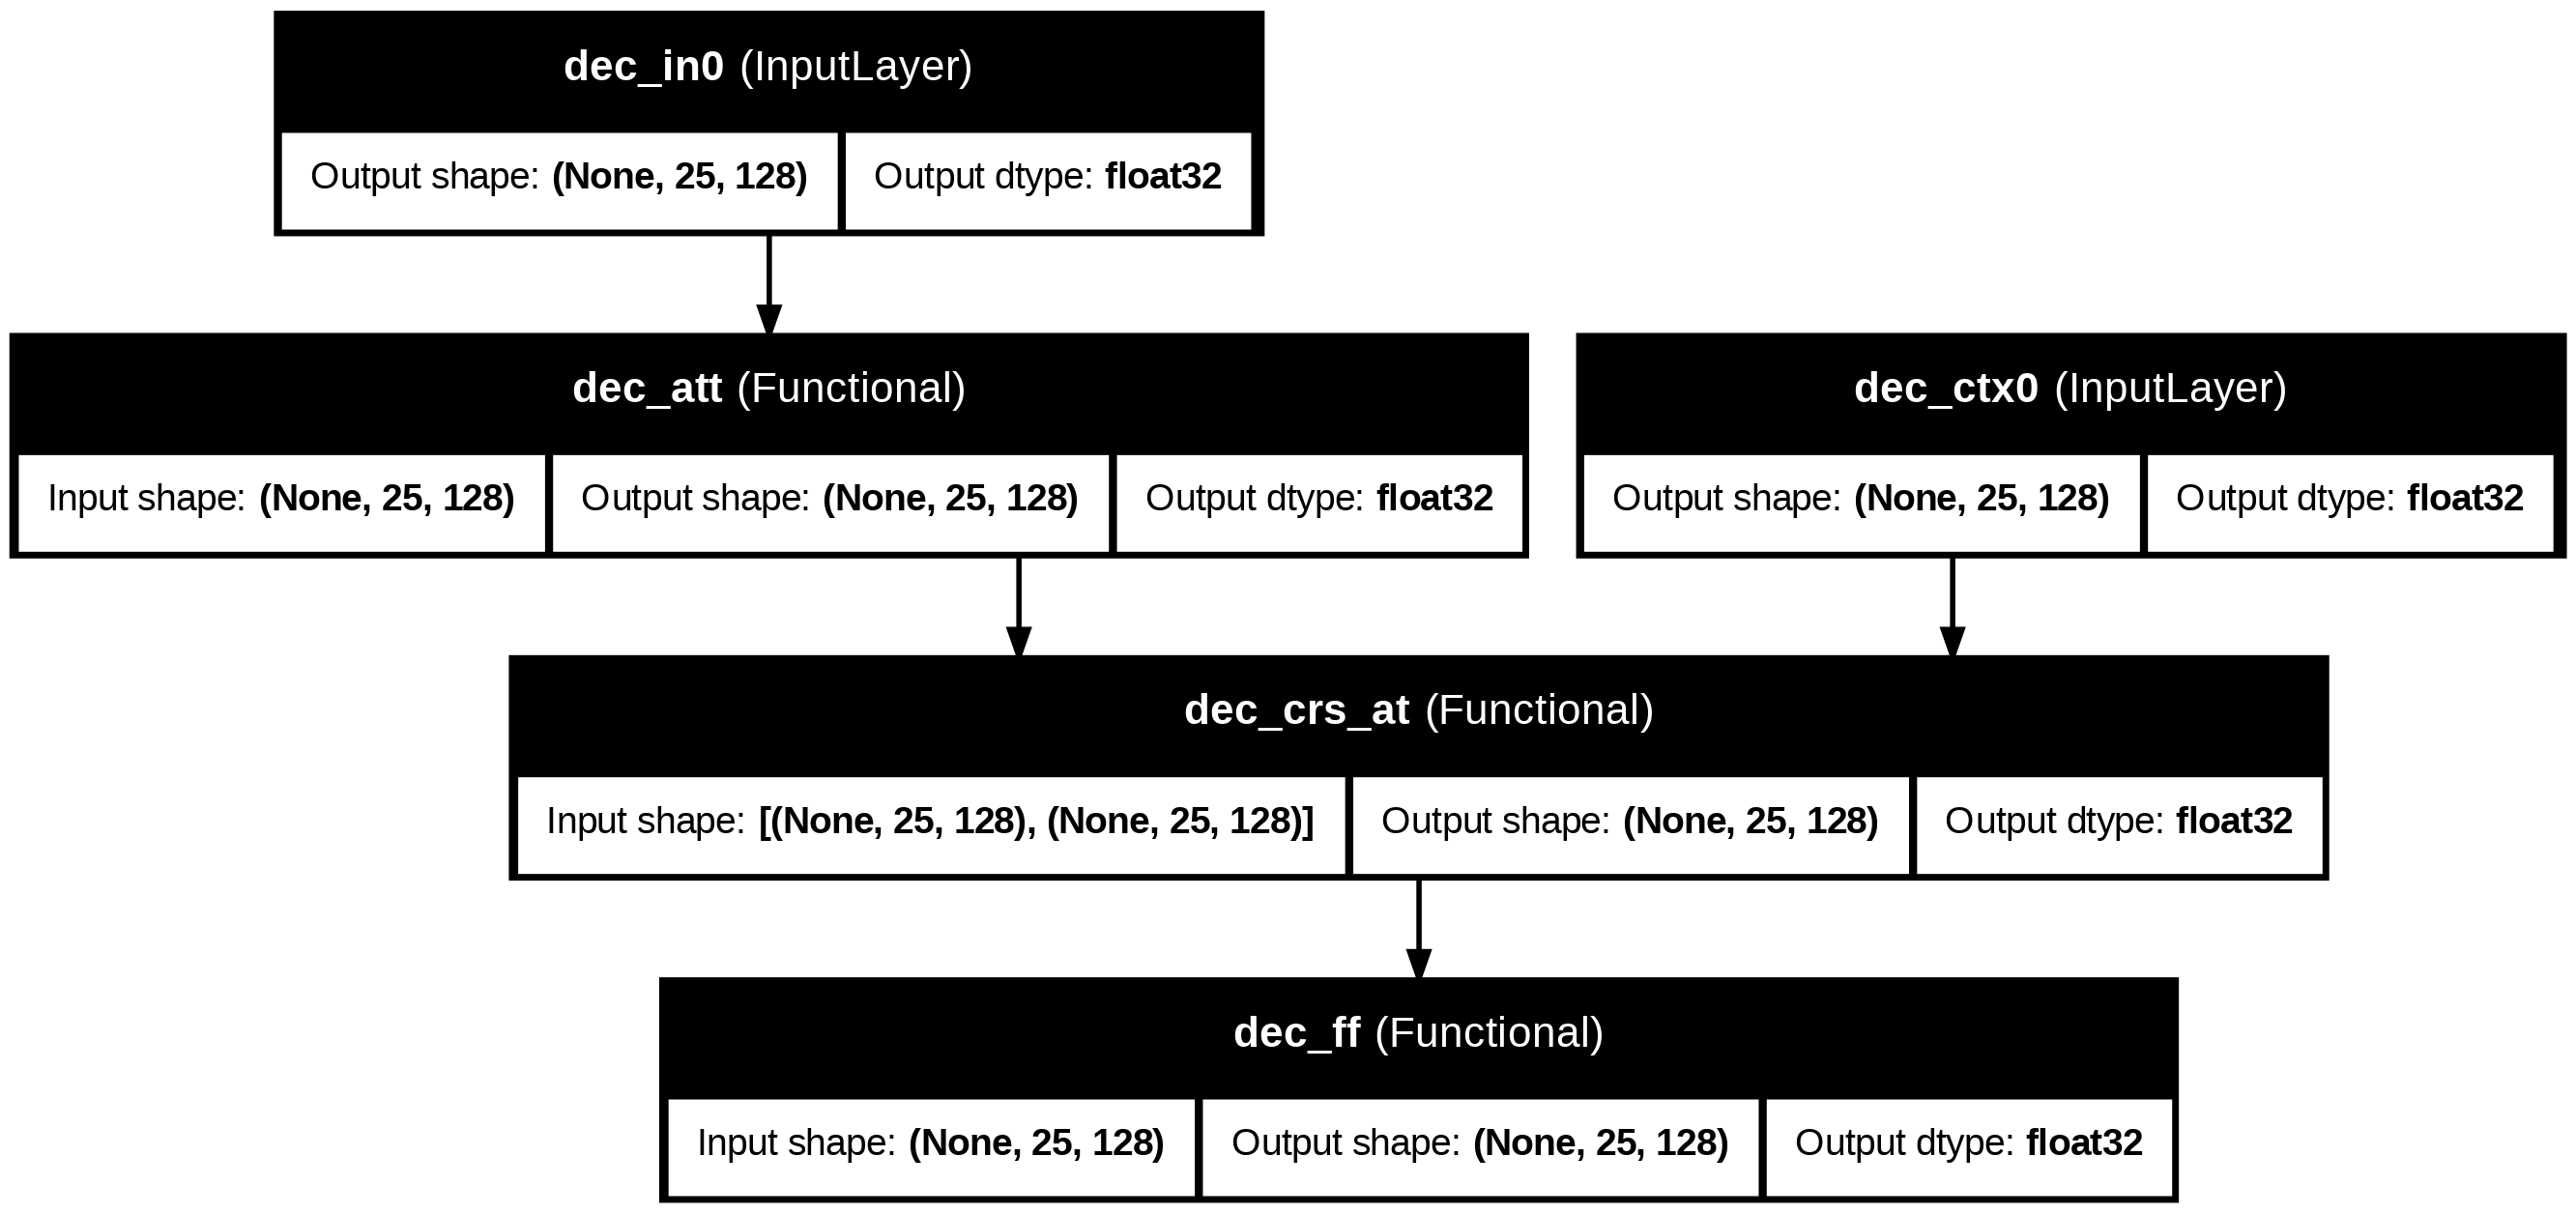

In [108]:
tf.keras.utils.plot_model(model,show_shapes = True, show_dtype = True, show_layer_names = True, show_layer_activations = True )

In [109]:
def transformer(num_layers, num_heads, seq_length, key_dim, ff_dim, vocab_size_en, vocab_size_fr, dropout=0.1, name='transformer'):
    # Define encoder and decoder inputs
    input_enc = tf.keras.layers.Input(shape=(seq_length,), dtype='int32', name='encode_inp')
    input_dec = tf.keras.layers.Input(shape=(seq_length,), dtype='int32', name='decode_inp')

    # Positional embeddings for encoder and decoder inputs
    emb_enc = PositionalEmbedding(seq_length, vocab_size_en, key_dim, name='embed_enc')
    emb_dec = PositionalEmbedding(seq_length, vocab_size_fr, key_dim, name='embed_dec')

    # Create encoder and decoder layers
    encoders = [encoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim, dropout=dropout, prefix=f"enc{i}", num_heads=num_heads)
                for i in range(num_layers)]
    decoders = [decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim, dropout=dropout, prefix=f"dec{i}", num_heads=num_heads)
                for i in range(num_layers)]

    # Final dense layer
    final = tf.keras.layers.Dense(vocab_size_fr, name='linear')

    # Apply encoder and decoder layers to inputs
    x1 = emb_enc(input_enc)
    x2 = emb_dec(input_dec)
    for layer in encoders:
        x1 = layer(x1)
    for layer in decoders:
        x2 = layer([x2, x1])

    # Generate output
    output = final(x2)

    try:
        del output.keras_mask
    except:
        pass

    # Define transformer model
    model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output, name=name)

    return model


In [110]:
seq_length = 25
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000

In [111]:
model = transformer(num_layers, num_heads, seq_length, key_dim, ff_dim, vocab_size_en, vocab_size_fr, dropout )

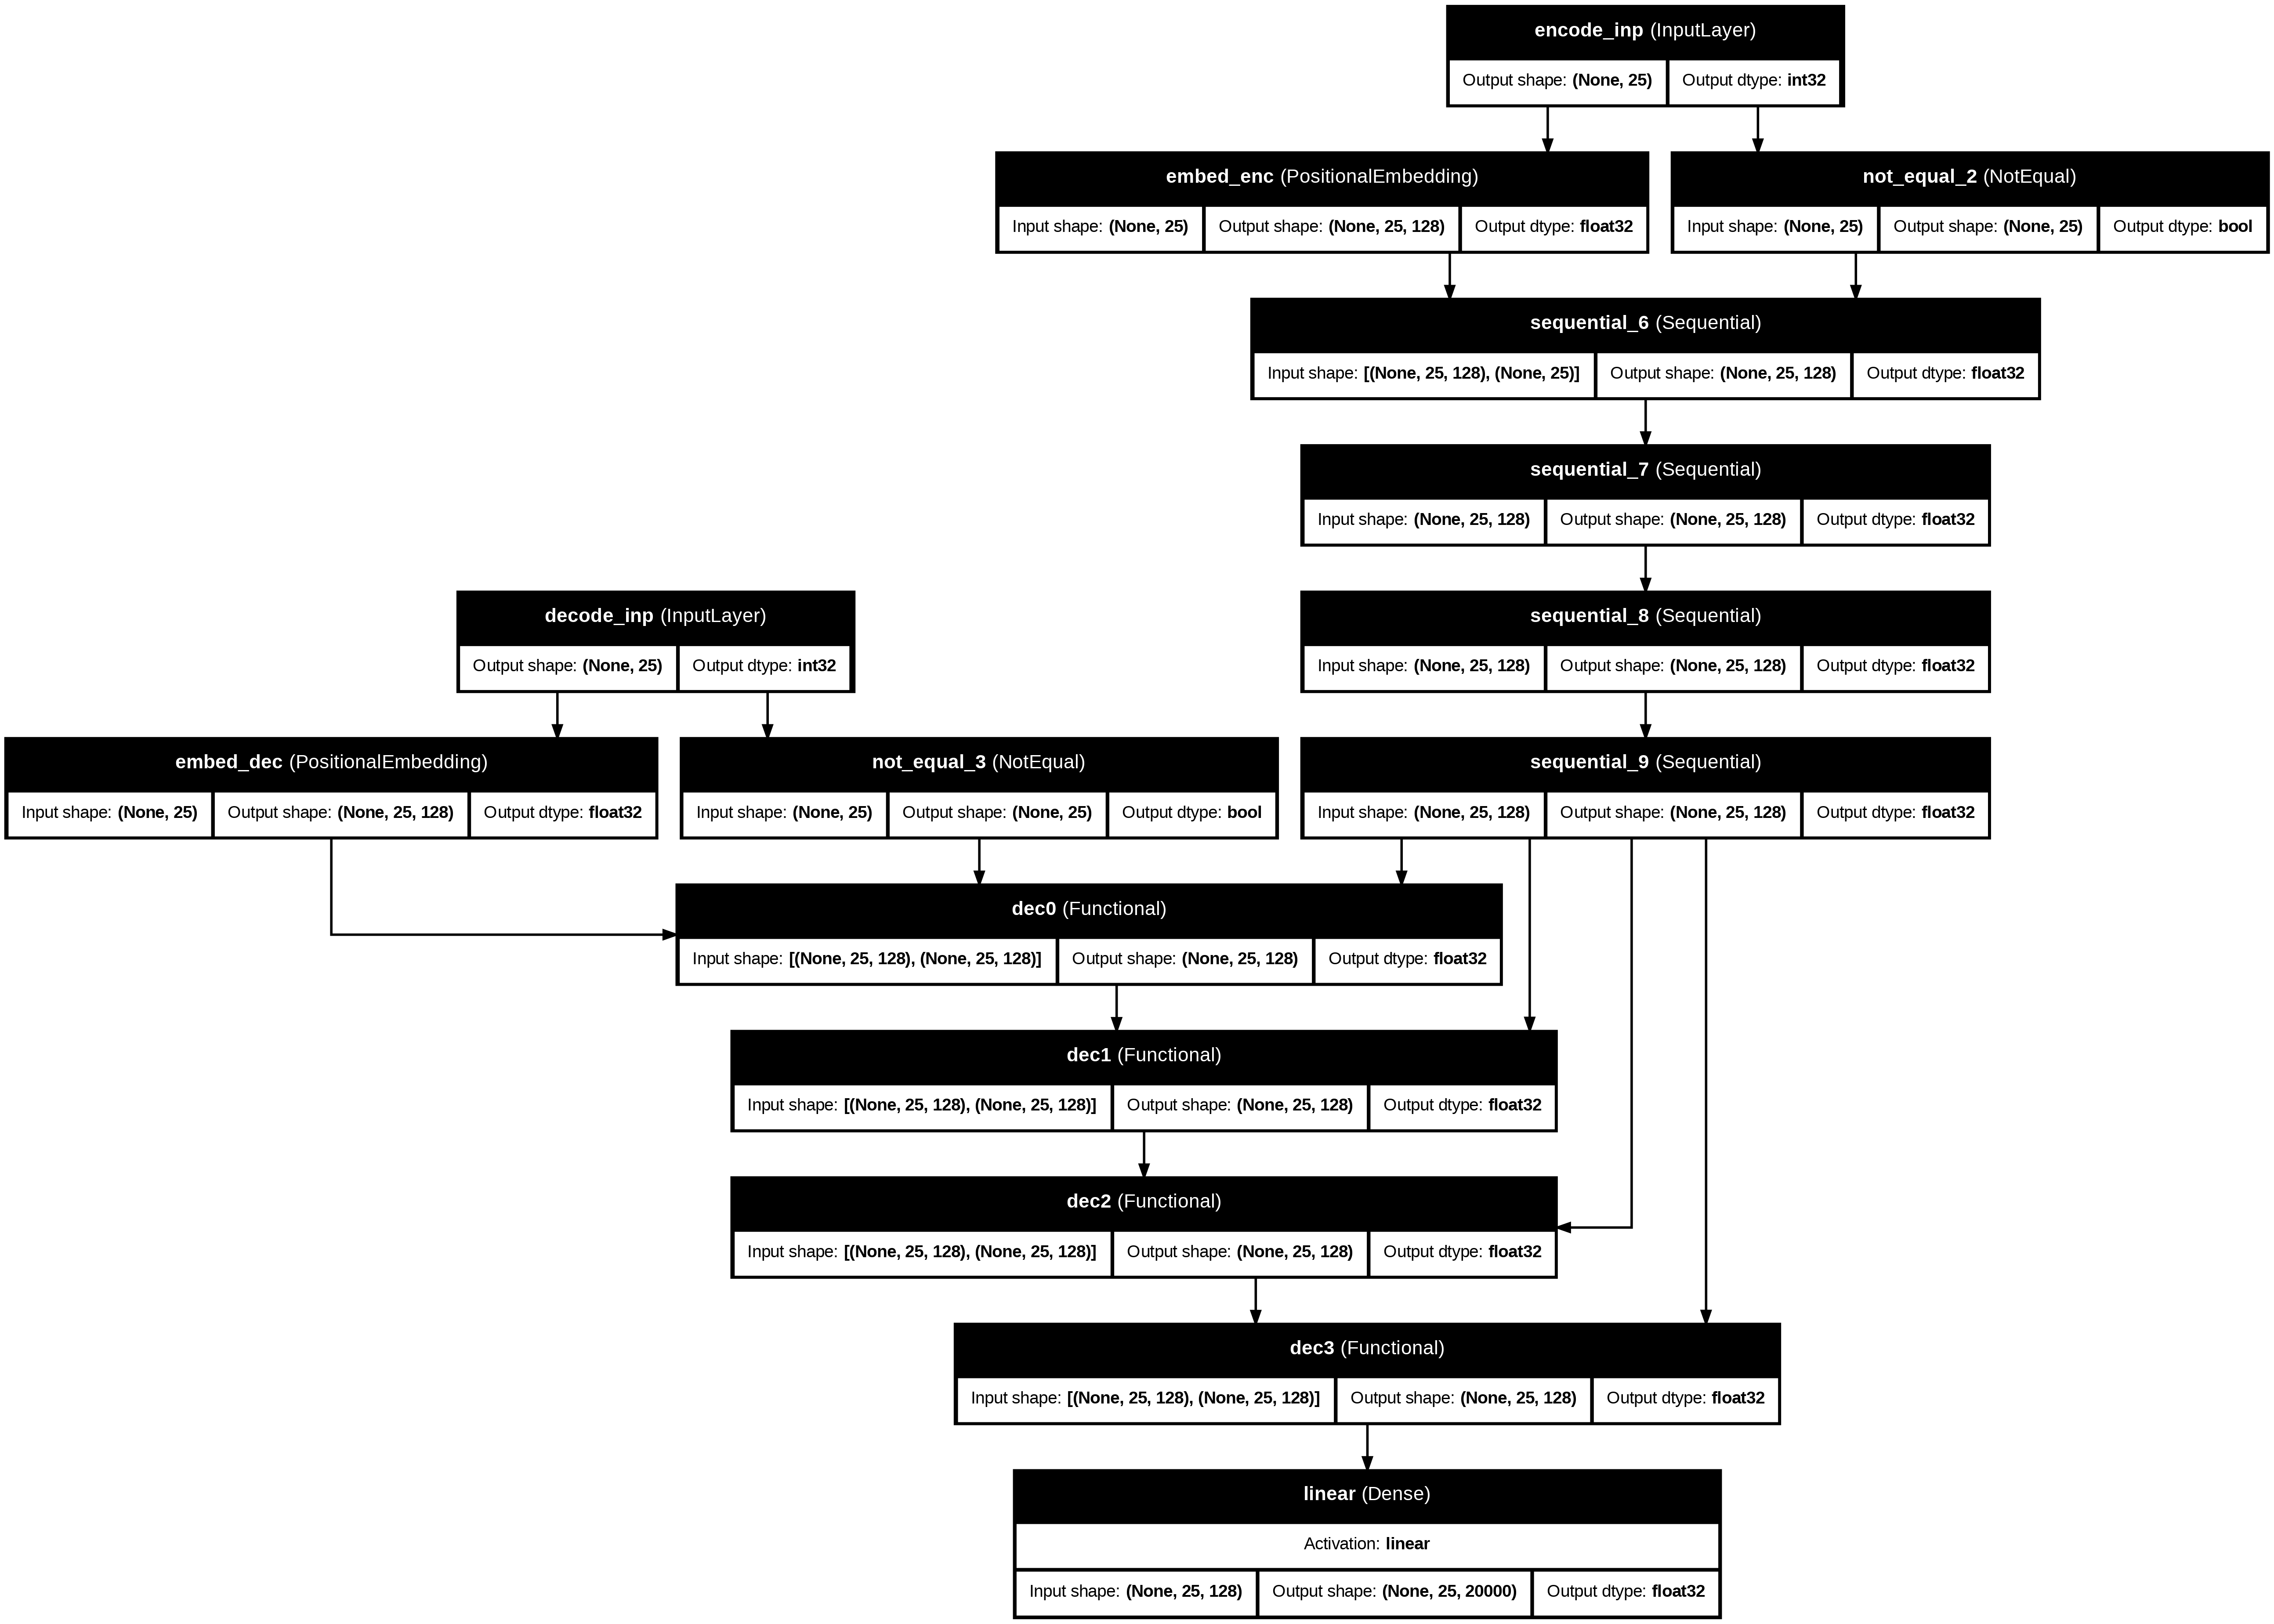

In [112]:
tf.keras.utils.plot_model(model,show_shapes = True, show_dtype = True, show_layer_names = True, show_layer_activations = True )

In [113]:
import tensorflow as tf

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, key_dim, warmup_steps=40000):
    super().__init__()
    self.key_dim = key_dim
    self.warmup_steps = warmup_steps
    self.d = tf.cast(self.key_dim, tf.float32)

  def __call__(self, step):
    # Convert step to float32
    step = tf.cast(step, dtype=tf.float32)
    # Calculate learning rate schedule
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    # Configuration for serialization
    config ={
      "key_dim": self.key_dim,
      "warmup_steps": self.warmup_steps
    }
    return config

# Define key dimension and create learning rate schedule
key_dim = 128
lr_schedule = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1 = .9, beta_2 = .98, epsilon = 1e-9)


In [114]:
def masked_loss(label, pred):
  # Create mask for non-padded tokens
  mask = label != 0

  # Sparse categorical cross-entropy loss
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none'
  )
  loss = loss_object(label, pred)

  # Apply mask to loss
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  # Compute average loss
  loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
  return loss


In [115]:
def mask_accuracy(label, pred):
  # Convert predictions to class labels
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)

  # Calculate match between labels and predictions
  match = label == pred

  # Apply mask to match
  mask = label != 0
  match = match & mask

  # Compute accuracy
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match) / tf.reduce_sum(mask)


In [116]:
# Compile the model with custom loss and metrics
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[mask_accuracy])
model.summary()

# Train the model



Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encode_inp (InputLayer)   │ (None, 25)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embed_enc                 │ (None, 25, 128)        │      1,280,000 │ encode_inp[0][0]       │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, 25)             │              0 │ encode_inp[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, 25, 128)        │        659,712 │ embed_enc[0][0],       │
│                           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 25, 128)        │        659,712 │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decode_inp (InputLayer)   │ (None, 25)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, 25, 128)        │        659,712 │ sequential_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embed_dec                 │ (None, 25, 128)        │      2,560,000 │ decode_inp[0][0]       │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (None, 25, 128)        │        659,712 │ sequential_8[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, 25)             │              0 │ decode_inp[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dec0 (Functional)         │ (None, 25, 128)        │      1,187,456 │ embed_dec[0][0],       │
│                           │                        │                │ sequential_9[0][0],    │
│                           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dec1 (Functional)         │ (None, 25, 128)        │      1,187,456 │ dec0[0][0],            │
│                           │                        │                │ sequential_9[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dec2 (Functional)         │ (None, 25, 128)        │      1,187,456 │ dec1[0][0],            │
│                           │                        │                │ sequential_9[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dec3 (Functional)         │ (None, 25, 128)        │      1,187,456 │ dec2[0][0],            │
│                           │                        │                │ sequential_9[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ linear (Dense)            │ (None, 25, 20000)      │      2,580,000 │ dec3[0][0]             │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,808,672 (52.68 MB)

 Trainable params: 13,808,672 (52.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_ds, epochs=20, validation_data=test_ds)

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Training history')
x = list(range(1, 21))
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="mask_accuracy")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_mask_accuracy")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="lower right")
plt.show()


In [ ]:
def translate(sentence):
    enc_tokens = eng_vect([sentence])
    lookup = list(fre_vect.get_vocabulary())
    start_sent, end_sent = "[start]", "[end]"
    output_sent = [start_sent]
    for i in range(seq_length):
        vector = fre_vect([" ".join(output_sent)])
        assert vector.shape == (1, seq_length + 1)
        dec_tokens = vector[:, :-1]
        assert dec_tokens.shape == (1, seq_length)
        pred = model([enc_tokens, dec_tokens])
        assert pred.shape == (1, seq_length, vocab_size_fr)
        word = lookup[np.argmax(pred[0, i, :])]
        output_sent.append(word)
        if word == end_sent:
            break
    return output_sent



In [ ]:
test_count = 20
for n in range(test_count):
    eng_sent, fre_sent = random.choice(test_pair)
    translated = translate(eng_sent)
    print(f"Test case: {n}")
    print(f"English sentence: {eng_sent}")
    print(f"Translated sentence: {' '.join(translated)}")
    print(f"French sentence: {fre_sent}")
    print()